In [1]:
"""
Portfolio optimization with CVXPY
Author: Thao Tran
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from cvxpy import *
import yfinance as yf

In [33]:
# Create a function to download historical close price data using yfinance
def download_data(tickers, start_date, end_date):
    mp = yf.download(tickers, start=start_date, end=end_date)['Close']
    return mp

#download stocks that you want to invest
tickers = ['GOOGL', 'AAPL', 'MSFT', 'AMZN', 'NVDA']
start_date = '2015-01-01'
end_date = '2025-02-10'

# Download data with yfinance
mp = download_data(tickers, start_date, end_date)


[*********************100%***********************]  5 of 5 completed


In [34]:
# 1. Monthly Price and less volatily stocks
# read monthly_prices.csv
#mp = pd.read_csv("/Users/thanhthaopro/Downloads/monthly_prices.csv",index_col=0)
mp.index = pd.to_datetime(mp.index)  # Ensure index is datetime
mr = pd.DataFrame()
mp

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Date,,,,,
2015-01-02,24.320433,15.426000,26.381865,40.152489,0.483143
2015-01-05,23.635284,15.109500,25.879185,39.783260,0.474983
2015-01-06,23.637510,14.764500,25.240503,39.199333,0.460582
2015-01-07,23.968962,14.921000,25.166271,39.697376,0.459382
2015-01-08,24.889902,15.023000,25.253954,40.865196,0.476663
...,...,...,...,...,...
2025-02-03,227.759583,237.419998,201.229996,410.920013,116.660004
2025-02-04,232.544327,242.059998,206.380005,412.369995,118.650002
2025-02-05,232.214691,236.169998,191.330002,413.290009,124.830002


In [40]:
# compute monthly returns
for s in mp.columns:
    date = mp.index[0]
    pr0 = mp[s][date] 
    for t in range(1, len(mp.index)):
        date = mp.index[t]
        pr1 = mp[s][date]
        ret = (pr1 - pr0) / pr0
        mr.loc[date, s] = ret  # Use loc instead of set_value
        pr0 = pr1
        
# get symbol names
symbols = mr.columns

# convert monthly return data frame to a numpy matrix
return_data = mr.values.T  # Use .values instead of as_matrix

# compute mean return
r = np.asarray(np.mean(return_data, axis=1))

# covariance
C = np.asmatrix(np.cov(return_data))

# print out expected return and std deviation
print("----------------------")
for j in range(len(symbols)):
    print('%s: Exp ret = %f, Risk = %f' % (symbols[j], r[j], C[j, j]**0.5))
   

# set up optimization model
n = len(symbols)
x = Variable(n)
req_return = 0.002
ret = r.T @ x  # Use @ for matrix multiplication
risk = quad_form(x, C)
prob = Problem(Minimize(risk), 
               [sum(x) == 1, ret >= req_return,
                x >= 0])

# solve problem and write solution
try:
    prob.solve()
    print("----------------------")
    print("Optimal portfolio")
    print("----------------------")
    for s in range(len(symbols)):
        print('x[%s] = %f' % (symbols[s], x.value[s]))
    print("----------------------")
    print('Exp ret = %f' % (ret.value))
    print('risk    = %f' % ((risk.value)**0.5))
    print("----------------------")
except Exception as e:
    print(f"Error: {e}")

----------------------
AAPL: Exp ret = 0.001041, Risk = 0.001608
AMZN: Exp ret = 0.001274, Risk = 0.002007
GOOGL: Exp ret = 0.000929, Risk = 0.001615
MSFT: Exp ret = 0.001061, Risk = 0.001491
NVDA: Exp ret = 0.002676, Risk = 0.003828
----------------------
Optimal portfolio
----------------------
x[AAPL] = 0.156053
x[AMZN] = 0.265775
x[GOOGL] = 0.000000
x[MSFT] = 0.030007
x[NVDA] = 0.548165
----------------------
Exp ret = 0.002000
risk    = 0.002289
----------------------


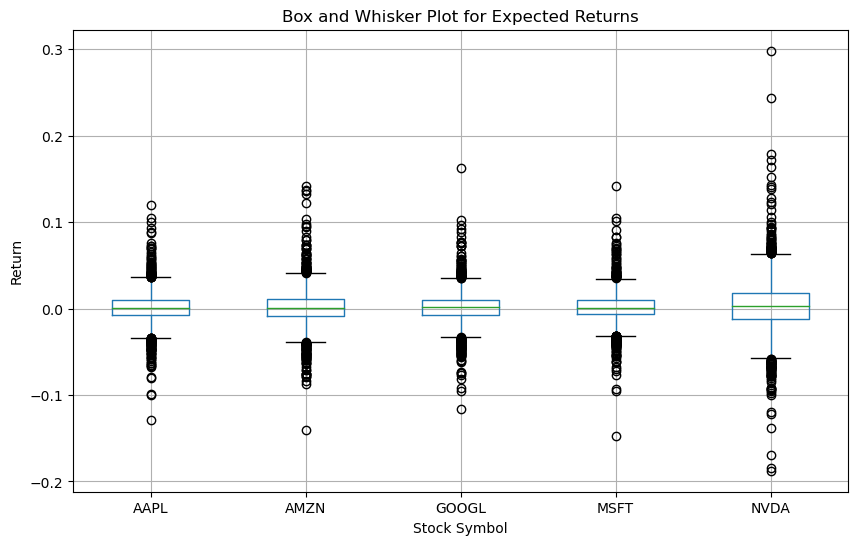

In [41]:
import matplotlib.pyplot as plt

# Assuming 'mr' is your DataFrame of returns (e.g., monthly returns)
# Each column in 'mr' represents a stock's return history.

plt.figure(figsize=(10,6))
mr.boxplot()
plt.title('Box and Whisker Plot for Expected Returns')
plt.xlabel('Stock Symbol')
plt.ylabel('Return')
plt.show()